In [69]:
import pprint as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

from itertools import chain
from collections import Counter, OrderedDict
from pandas.tseries.offsets import BDay
from pandas.tseries.holiday import *
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.externals import joblib
from scipy.stats import pearsonr
from tap import modelmetrics, modelparams

In [70]:
# Constants
params = modelparams.get_constants()
dirs = modelparams.get_data_dir()
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
accident_severity_mapping = {
    1: "Fatal",
    2: "Severe",
    3: "Slight"
}
day_of_week_mapping = {
    1: "Sun",
    2: "Mon",
    3: "Tue",
    4: "Wed",
    5: "Thu",
    6: "Fri",
    7: "Sat"    
}
one_hot_feature_mapping = joblib.load("./feature_mapping.oh.pkl.xz")
droppable_columns = np.array(["Longitude", "Latitude"])

In [147]:
# Classes and functions
# Plot a global mean horizontal line on a line plot for labels freater than min_label
# Otherwise, plot a histogram of counts per label on select_col
def plot_mean_relation_with(data, fig, select_col, nrow = -1, ncol = 3, ind = 1, exclusion_list = None, min_label = 5):
    if not isinstance(select_col, str):
        print('Only 1 feature can be selected')
        return
    if select_col not in data.columns:
        print('Selected column must contain in the dataframe')
        return
    data_cols = data.columns.drop(select_col) if exclusion_list is None else data.columns.drop(exclusion_list + [select_col])
    if nrow < 0:
        nrow = np.ceil(len(data_cols) / ncol) + 2
    global_mean = data[select_col].mean()
    
    countplot_cols = list()
    for col in data_cols:
        if len(pd.unique(data[col])) > min_label:
            ax = fig.add_subplot(nrow, ncol, ind)
            ax.plot(data.loc[:, (col, select_col)].groupby(col).mean())
            ax.axhline(global_mean, color = 'r', linestyle = '--')
        else:
            countplot_cols.append(col)
            continue
        ax.set_title(col.replace('_', ' '))
        if len(data_cols) - len(countplot_cols) - ind <= ncol + len(countplot_cols):
            ax.set_xlabel('Label')
        if ind % ncol == 1:
            ax.set_ylabel(select_col + ' (Mean)')
        ind += 1

    if (ind - 1) % ncol != 0:
        ind += (ind % ncol) + 1
    
    for col in countplot_cols:
        ax = fig.add_subplot(nrow, ncol, ind)
        sns.countplot(data = data, ax = ax, x = col, hue = select_col)
        ind += 1
        
def plot_lv_relation_with(data, fig, dv, hue = None, nrow = -1, ncol = 3, ind = 1, exclusion_list = None, 
                         orient = 'v'):
    if not isinstance(dv, str):
        print('Independant variable must be single feature')
        return
    data_cols = data.columns.drop(dv) if exclusion_list is None else data.columns.drop(exclusion_list + [dv])
    if nrow < 0:
        nrow = np.ceil(len(data_cols) / ncol) + 2
    
    for col in data_cols:
        ax = fig.add_subplot(nrow, ncol, ind)
        if hue is not None:
            sns.lvplot(data = data, x = col, y = dv, hue = hue, ax = ax, orient = orient)
        else:
            sns.lvplot(data = data, x = col, y = dv, ax = ax, orient = orient)
        if ind % ncol != 1:
            ax.set_ylabel('')
        ind += 1
    sns.despine()
    
    return ind
    
def drop_records_after(before, after):
    return after.drop(after.index[after.set_index('Accident_Index').index.isin(before.set_index('Accident_Index').index) ^ True], 
         axis=0)

# Create calender of GB Bank Holidays
class UKBankHolidays(AbstractHolidayCalendar):
    rules = [
        Holiday('New Years Day', month=1, day=1, observance=sunday_to_monday),
        GoodFriday,
        EasterMonday,
        Holiday('Early May Bank', month=5, day=1, observance=DateOffset(weekday=MO(1))),
        Holiday('Spring Bank', month=5, day=25, observance=DateOffset(weekday=MO(1))),
        Holiday('Summer Bank', month=8, day=25, observance=DateOffset(weekday=MO(1))),
        Holiday('Christmas Day', month=12, day=25, observance=sunday_to_monday),
        Holiday('Boxing Day', month=12, day=26, observance=next_monday_or_tuesday)
    ]
    
def dt_general_plotter(ax, data, by, label, scaler = MinMaxScaler()):
    return ax.plot(*zip(*[
        (yr, cnt[0])
        for yr, cnt in zip(range(min(by), max(by) + 1), 
                           scaler.fit_transform(np.array(data.groupby(by).count()).reshape(-1, 1)))
    ]), label=label)
    
def plot_yearly_missing_data_cols(data, fig, nrow = -1, ncol = 3, ind = 1):
    missing_cols = sorted([(x, col) for col, x in zip(data.columns, data.isnull().sum(axis=0).tolist()) if x > 0])
    if nrow < 0:
        nrow = np.ceil(len(missing_cols) / 3)

    for (x, col) in missing_cols:
        ax = fig.add_subplot(nrow, ncol, ind)
        missing_group = data.loc[:, ('Year', col)].groupby('Year').apply(lambda x: x.loc[x[col].isnull(), 'Year'].count())
        percent_missing = np.round((x/len(data)) * 100, 2)
        ax.bar(*zip(*[(ind, val) for ind, val in zip(missing_group.index, missing_group)]), 
               label='Total: ' + str(x) + " (" + (str(percent_missing) if percent_missing >= 0.01 else "0.01") + "%)")
        ax.set_title(col.replace('_', ' '))
        if len(missing_cols) - ind < ncol:
            ax.set_xlabel('Year')
            ax.set_xticks(sorted(data["Year"].unique()))
        else:
            ax.set_xticks([])
        if ind % ncol == 1:
            ax.set_ylabel('Frequency')
        ind += 1
        ax.legend()
        
# Plot Pearson correlation coefficient
def plot_pearsonr(data):
    corr = data.copy().corr()
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 20))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
def auto_drop(data):
    mask = np.isin(droppable_columns, data.columns)
    return data.drop(droppable_columns[mask], axis=1) if any(mask) else data
    
def plot_stacked_bar_severity(data, by, ax):
    tmp = data.groupby([by, "Accident_Severity"]).count()["Accident_Index"]
    
    slight = list(tmp[list(range(2, len(tmp), 3))])
    severe = list(tmp[list(range(1, len(tmp), 3))])
    fatal = list(tmp[list(range(0, len(tmp), 3))])
    chrono = sorted(data[by].unique())
    
    p1 = ax.bar(chrono, slight, label="Slight")
    p2 = ax.bar(chrono, severe, bottom=slight, label="Severe")
    p3 = ax.bar(chrono, fatal, bottom=np.add(slight, severe), color='#d62728', label="Fatal")

    ax.set_ylabel('Number of Accidents')
    ax.set_xlabel(by)
    ax.set_title('Frequency of Each Accident Severity By ' + by)
    ax.set_xticks(chrono)
    
    return [p1, p2, p3]


In [72]:
# Import original data
acc = pd.read_csv(dirs["orig"] + 'acc2005_2016.csv')
cas = pd.read_csv(dirs["orig"] + 'cas2005_2016.csv')
veh = pd.read_csv(dirs["orig"] + 'veh2005_2016.csv')

# Replace all -1 missing values to NA
acc.replace(-1, np.nan, inplace=True)
veh.replace(-1, np.nan, inplace=True)
cas.replace(-1, np.nan, inplace=True)

C:\Anaconda\envs\fyp_tap_env\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Preprocessing

In [73]:
# Tidy up columns names
acc.rename(lambda x: x.replace('.', ''), axis=1, inplace=True) # Inplace to ensure it changes the variable itself
acc.rename(columns={
    'Speed_limit': 'Speed_Limit',
    'Pedestrian_CrossingHuman_Control': 'Pedestrian_Crossing_Human_Control',
    'Pedestrian_CrossingPhysical_Facilities': 'Pedestrian_Crossing_Physical_Facilities'
}, inplace=True)

veh.rename(lambda x: x.replace('.', ''), axis=1, inplace=True)
veh.rename(columns={
    'Vehicle_LocationRestricted_Lane': 'Vehicle_Location_Restricted_Lane'
}, inplace=True)


In [74]:
# Date Time cannot be imputed since there is no way to "guess" the date an accident occur, remove associated records
acc.dropna(subset=['Time', 'Speed_Limit'], inplace=True)
acc['Speed_Limit'] = acc['Speed_Limit'].astype('int64')

# We know that if the accident record doesn't exist, the vehicle record cannot exist. Therefore, remove vehicle records 
# that no longer have an associating accident
veh.drop(veh.index[veh.set_index('Accident_Index').index.isin(acc.set_index('Accident_Index').index) ^ True], 
         axis=0, inplace=True)

# Was_Vehicle_Left_Hand_Drive feature cannot be imputed as it is part of the aim factor of the project
veh_ind = list(set(veh.loc[veh['Was_Vehicle_Left_Hand_Drive'].isnull(), 'Accident_Index']))

# Remove every record that has the feature with missing value alongside vehicles incolved with the same Accident_Index
veh.drop(veh.index[veh.set_index('Accident_Index').index.isin(veh_ind) ^ False], axis=0, inplace=True)
veh['Was_Vehicle_Left_Hand_Drive'] = veh['Was_Vehicle_Left_Hand_Drive'].astype('int64')

# Remove every Accidents which is associated with the removed Vehicles
acc.drop(acc.index[acc.set_index('Accident_Index').index.isin(veh.set_index('Accident_Index').index) ^ True], 
         axis=0, inplace=True)

# Remove noisy features
acc.drop([
    'Location_Easting_OSGR', 'Location_Northing_OSGR', 'LSOA_of_Accident_Location',  
    'Local_Authority_District', # Local_Authority_Highway
    'Police_Force', 'Did_Police_Officer_Attend_Scene_of_Accident', # Police involvement unrelated
    'X1st_Road_Number', 'X2nd_Road_Number',
    # 'Longitude', 'Latitude', # Not used in modelling but useful in analysis
], axis=1, inplace=True)
veh.drop([
    'Vehicle_Reference', # Reference value not useful
    'Age_of_Driver', # Age_Band_of_Driver more general
    'Journey_Purpose_of_Driver' # Missing from 2005 - 2010
], axis=1, inplace=True)
cas.drop([
    'Age_of_Casualty', # Duplicate of Age_Band_of_Casualty
    'Casualty_Reference', 'Vehicle_Reference' # Reference value not useful
], axis=1, inplace=True)

acc.replace({
    'Road_Type': {9: np.nan},
    'Weather_Conditions': {9: np.nan}
}, inplace=True)
veh.replace({
    'Sex_of_Driver': {3: np.nan}
}, inplace=True)

# Integer encode
lah_le = LabelEncoder()
acc[["Local_Authority_Highway"]] = lah_le.fit_transform(acc[["Local_Authority_Highway"]])

# Combine Date and Time to utilise datetime utility from Pandas
acc['Date_Time'] = pd.to_datetime(acc['Date'] + ' ' + acc['Time'], format='%d/%m/%Y %H:%M')
acc.drop(['Date', 'Time'], axis=1, inplace=True)

# Create a new feature is_holiday to indicate if the accident occured on a holiday
ukhols = UKBankHolidays().holidays(min(acc['Date_Time']), max(acc['Date_Time']))
acc['Is_Holiday'] = 0
acc.loc[acc['Date_Time'].dt.date.apply(lambda x: x in ukhols), ('Is_Holiday')] = 1



C:\Anaconda\envs\fyp_tap_env\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [75]:
# Only Minute has no useful pattern as its an interval of 5 minutes.
# Day is already included as acc.Day_of_Week
acc['Year'], acc['Month'], acc['Hour'] = acc['Date_Time'].dt.year, acc['Date_Time'].dt.month, acc['Date_Time'].dt.hour

# Odd or questionable records caught during analysis which are removed later are placed in this cell
# Speed_Limit == 0 record, makes no sense to have any road with 0 speed limit
acc.drop(acc[acc['Speed_Limit'] == 0].index, inplace=True)
veh = drop_records_after(acc, veh)

In [76]:
###############END######################

# Analysis 1

C:\Anaconda\envs\fyp_tap_env\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


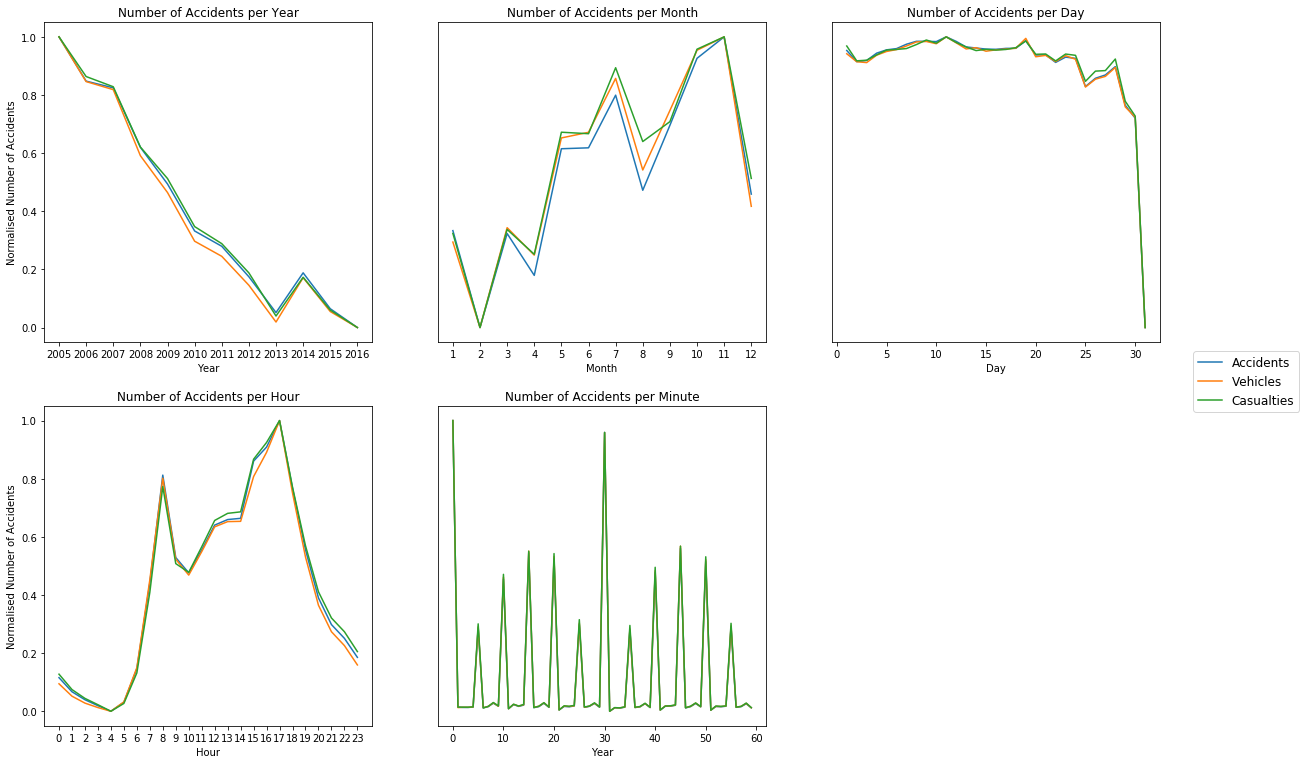

In [77]:
veh_ind = pd.DataFrame({
    'Accident_Index': veh['Accident_Index']
}).merge(acc.loc[:, ('Accident_Index', 'Date_Time')], on = 'Accident_Index', how = 'inner')
cas_ind = pd.DataFrame({
    'Accident_Index': cas['Accident_Index']
}).merge(acc.loc[:, ('Accident_Index', 'Date_Time')], on = 'Accident_Index', how = 'inner')
hold = 'Accident_Index'
dtm = 'Date_Time'

fig = plt.figure(figsize=[20,20])
nrow, ncol, ind = 3, 3, 1

# Year
ax = fig.add_subplot(nrow, ncol, ind)
dt_general_plotter(ax, acc[hold], acc[dtm].dt.year, 'Accidents', min_max_scaler)
dt_general_plotter(ax, veh_ind[hold], veh_ind[dtm].dt.year, 'Vehicles', min_max_scaler)
dt_general_plotter(ax, cas_ind[hold], cas_ind[dtm].dt.year, 'Casualties', min_max_scaler)
ax.set_xticks(acc[dtm].dt.year.unique())
ax.set_xlabel("Year")
ax.set_ylabel("Normalised Number of Accidents")
ax.set_title('Number of Accidents per Year')
ind += 1

# Month
ax = fig.add_subplot(nrow, ncol, ind)
dt_general_plotter(ax, acc[hold], acc[dtm].dt.month, 'Accidents', min_max_scaler)
dt_general_plotter(ax, veh_ind[hold], veh_ind[dtm].dt.month, 'Vehicles', min_max_scaler)
dt_general_plotter(ax, cas_ind[hold], cas_ind[dtm].dt.month, 'Casualties', min_max_scaler)
ax.set_xticks(acc[dtm].dt.month.unique())
ax.set_xlabel("Month")
ax.set_title('Number of Accidents per Month')
ax.set_yticks([])
ind += 1

# Day
ax = fig.add_subplot(nrow, ncol, ind)
dt_general_plotter(ax, acc[hold], acc[dtm].dt.day, 'Accidents', min_max_scaler)
dt_general_plotter(ax, veh_ind[hold], veh_ind[dtm].dt.day, 'Vehicles', min_max_scaler)
dt_general_plotter(ax, cas_ind[hold], cas_ind[dtm].dt.day, 'Casualties', min_max_scaler)
ax.set_title('Number of Accidents per Day')
ax.set_xlabel("Day")
ax.set_yticks([])
ind += 1

# Hour
ax = fig.add_subplot(nrow, ncol, ind)
dt_general_plotter(ax, acc[hold], acc[dtm].dt.hour, 'Accidents', min_max_scaler)
dt_general_plotter(ax, veh_ind[hold], veh_ind[dtm].dt.hour, 'Vehicles', min_max_scaler)
dt_general_plotter(ax, cas_ind[hold], cas_ind[dtm].dt.hour, 'Casualties', min_max_scaler)
ax.set_xticks(acc[dtm].dt.hour.unique())
ax.set_xlabel("Hour")
ax.set_ylabel("Normalised Number of Accidents")
ax.set_title('Number of Accidents per Hour')
ind += 1

# Minute
ax = fig.add_subplot(nrow, ncol, ind)
l1, = dt_general_plotter(ax, acc[hold], acc[dtm].dt.minute, 'Accidents', min_max_scaler)
l2, = dt_general_plotter(ax, veh_ind[hold], veh_ind[dtm].dt.minute, 'Vehicles', min_max_scaler)
l3, = dt_general_plotter(ax, cas_ind[hold], cas_ind[dtm].dt.minute, 'Casualties', min_max_scaler)
ax.set_title('Number of Accidents per Minute')
ax.set_xlabel("Year")
ax.set_yticks([])
ind += 1

fig.legend([l1, l2, l3], ["Accidents", "Vehicles", "Casualties"], loc="center right", fancybox=True, fontsize="large")
plt.show()

No handles with labels found to put in legend.


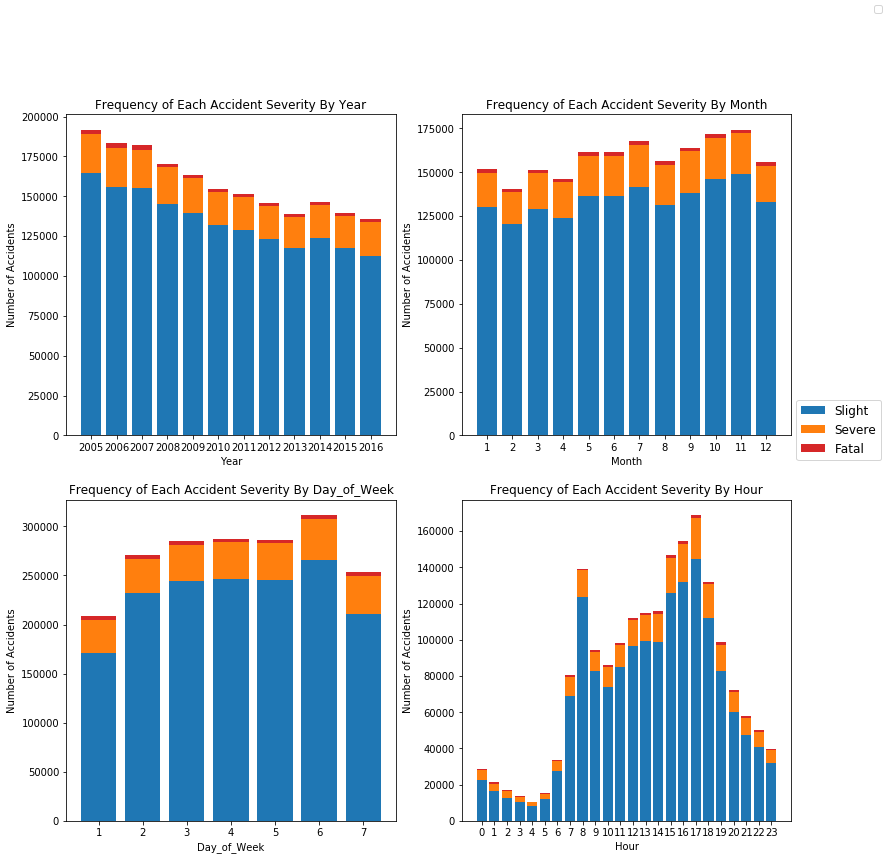

In [91]:
fig = plt.figure(figsize=[13, 13])
fig.legend()
ind = 221
leg = list()
for c in ["Year", "Month", "Day_of_Week", "Hour"]:
    ax = fig.add_subplot(ind)
    leg = plot_stacked_bar_severity(acc, c, ax)
    ind += 1

fig.legend(leg, ["Slight", "Severe", "Fatal"], loc="center right", fancybox=True, fontsize="large")
plt.show()

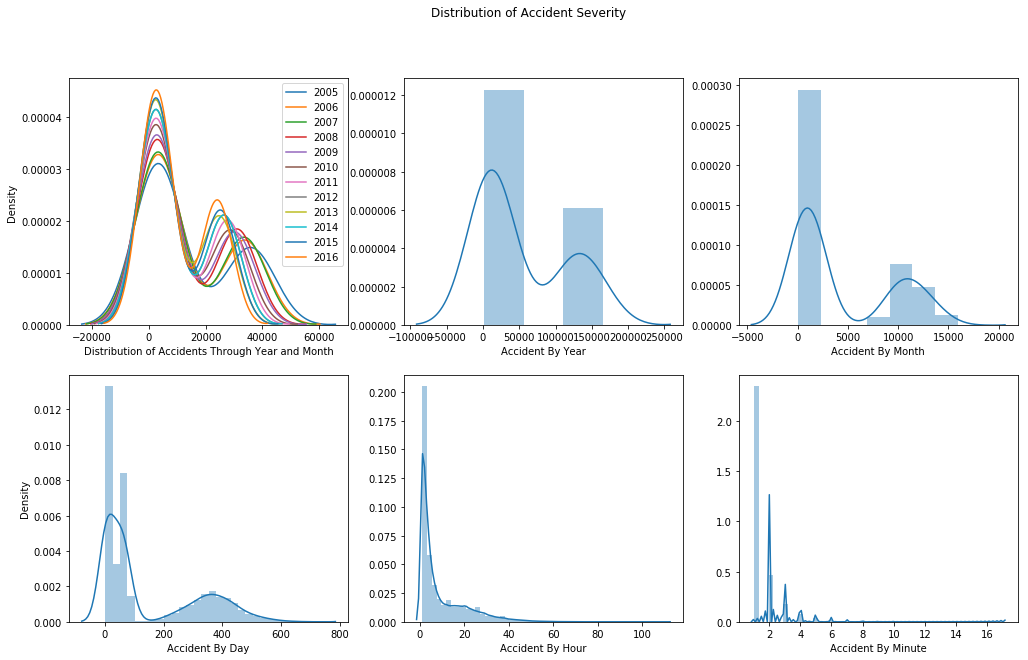

In [92]:
tmp = acc.merge(veh, on='Accident_Index').merge(cas, on='Accident_Index').groupby(
    ['Year', 'Month', 'Accident_Severity']).count()['Accident_Index']
ind = 231
fig = plt.figure(figsize=[17, 10])
fig.suptitle("Distribution of Accident Severity")
ax = fig.add_subplot(ind)
for yr in pd.unique(acc['Year']):
    sns.kdeplot(tmp[yr], label=str(yr), ax=ax)
ax.set_xlabel("Distribution of Accidents Through Year and Month")
ax.set_ylabel("Density")
ind += 1
ax = fig.add_subplot(ind)
sns.distplot(acc.groupby(['Year', acc['Accident_Severity']]).count()['Accident_Index'], axlabel='Accident By Year', ax=ax)
ind += 1
ax = fig.add_subplot(ind)
sns.distplot(acc.groupby(['Year', 'Month', acc['Accident_Severity']]).count()['Accident_Index'], axlabel='Accident By Month', ax=ax)
ind += 1
ax = fig.add_subplot(ind)
sns.distplot(acc.groupby(['Year', 'Month', acc['Date_Time'].dt.day, acc['Accident_Severity']]).count()['Accident_Index'], axlabel='Accident By Day', ax=ax)
ax.set_ylabel("Density")
ind += 1
ax = fig.add_subplot(ind)
sns.distplot(acc.groupby(['Year', 'Month', acc['Date_Time'].dt.day, acc['Date_Time'].dt.hour, acc['Accident_Severity']]).count()['Accident_Index'], axlabel='Accident By Hour', ax=ax)
ind += 1
ax = fig.add_subplot(ind)
sns.distplot(acc.groupby(['Year', 'Month', acc['Date_Time'].dt.day, acc['Date_Time'].dt.hour, acc['Date_Time'].dt.minute, acc['Accident_Severity']]).count()['Accident_Index'], axlabel='Accident By Minute', ax=ax)
plt.show()

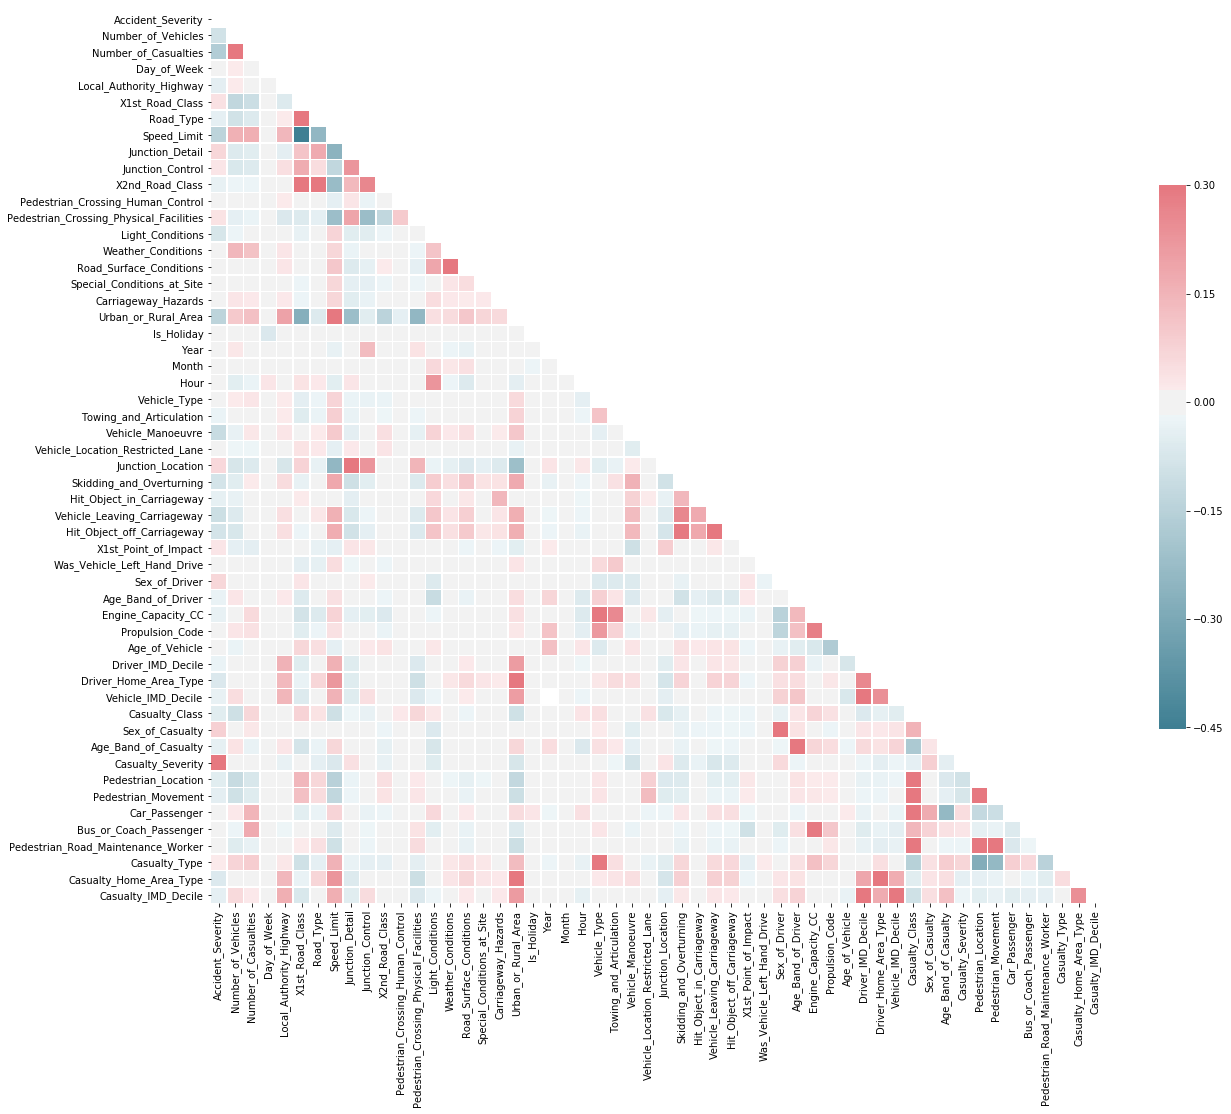

In [93]:
plot_pearsonr(auto_drop(acc.merge(veh, on="Accident_Index").merge(cas, on="Accident_Index")))

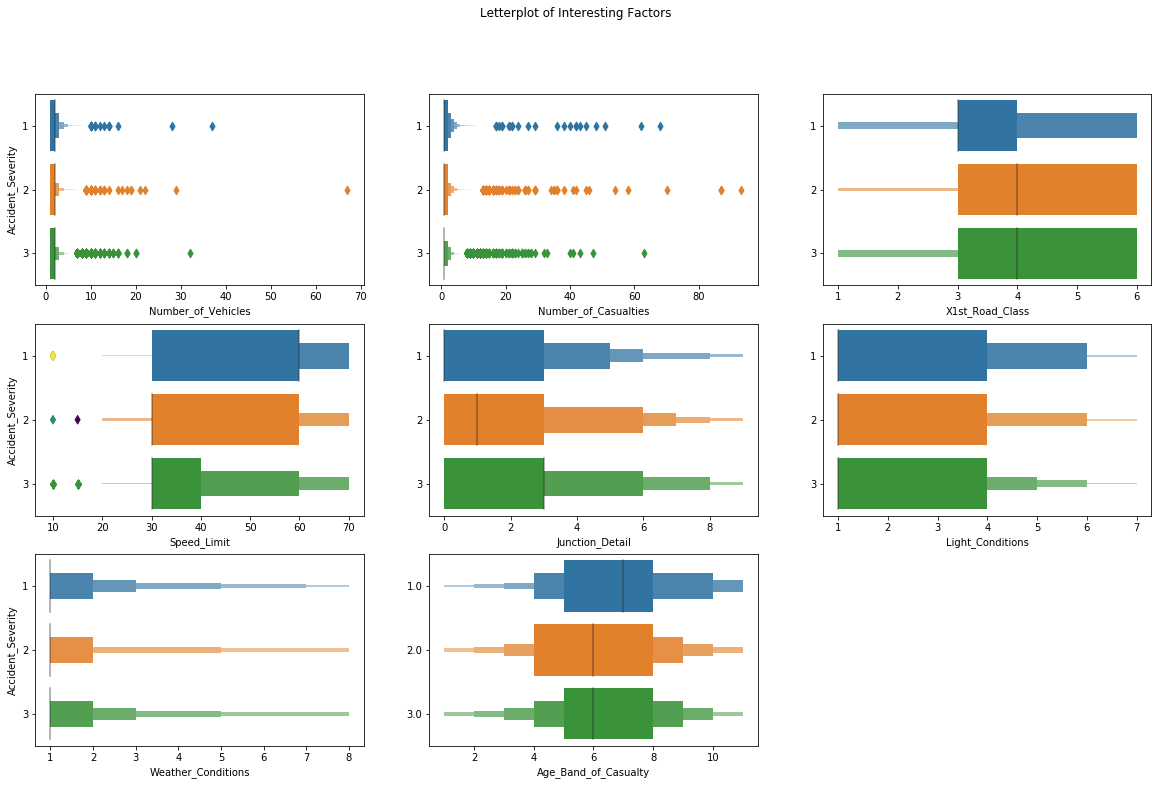

In [128]:
interesting_factors = np.array(["Accident_Severity", "Speed_Limit", "Age_Band_of_Casualty", "Weather_Conditions", 
                                "Light_Conditions", "Number_of_Vehicles", "Number_of_Casualties", "X1st_Road_Class", 
                               "Junction_Detail"])
fig = plt.figure(figsize=[20, 12])
nrow, ncol, ind = 3, 3, 1
ind = plot_lv_relation_with(data = acc[acc.columns[acc.columns.isin(interesting_factors)]], 
                            fig = fig, dv = 'Accident_Severity', orient = 'h', ncol = ncol, nrow = nrow, ind = ind)
castmp = cas.merge(acc[["Accident_Index", "Accident_Severity"]], how="left")
ind = plot_lv_relation_with(data = castmp[castmp.columns[castmp.columns.isin(interesting_factors)]], 
                            fig = fig, dv = 'Accident_Severity', orient = 'h', ncol = ncol, nrow = nrow, ind = ind)
fig.suptitle("Letterplot of Interesting Factors")
plt.show()
del castmp

In [ ]:
###############END######################

## Missing data

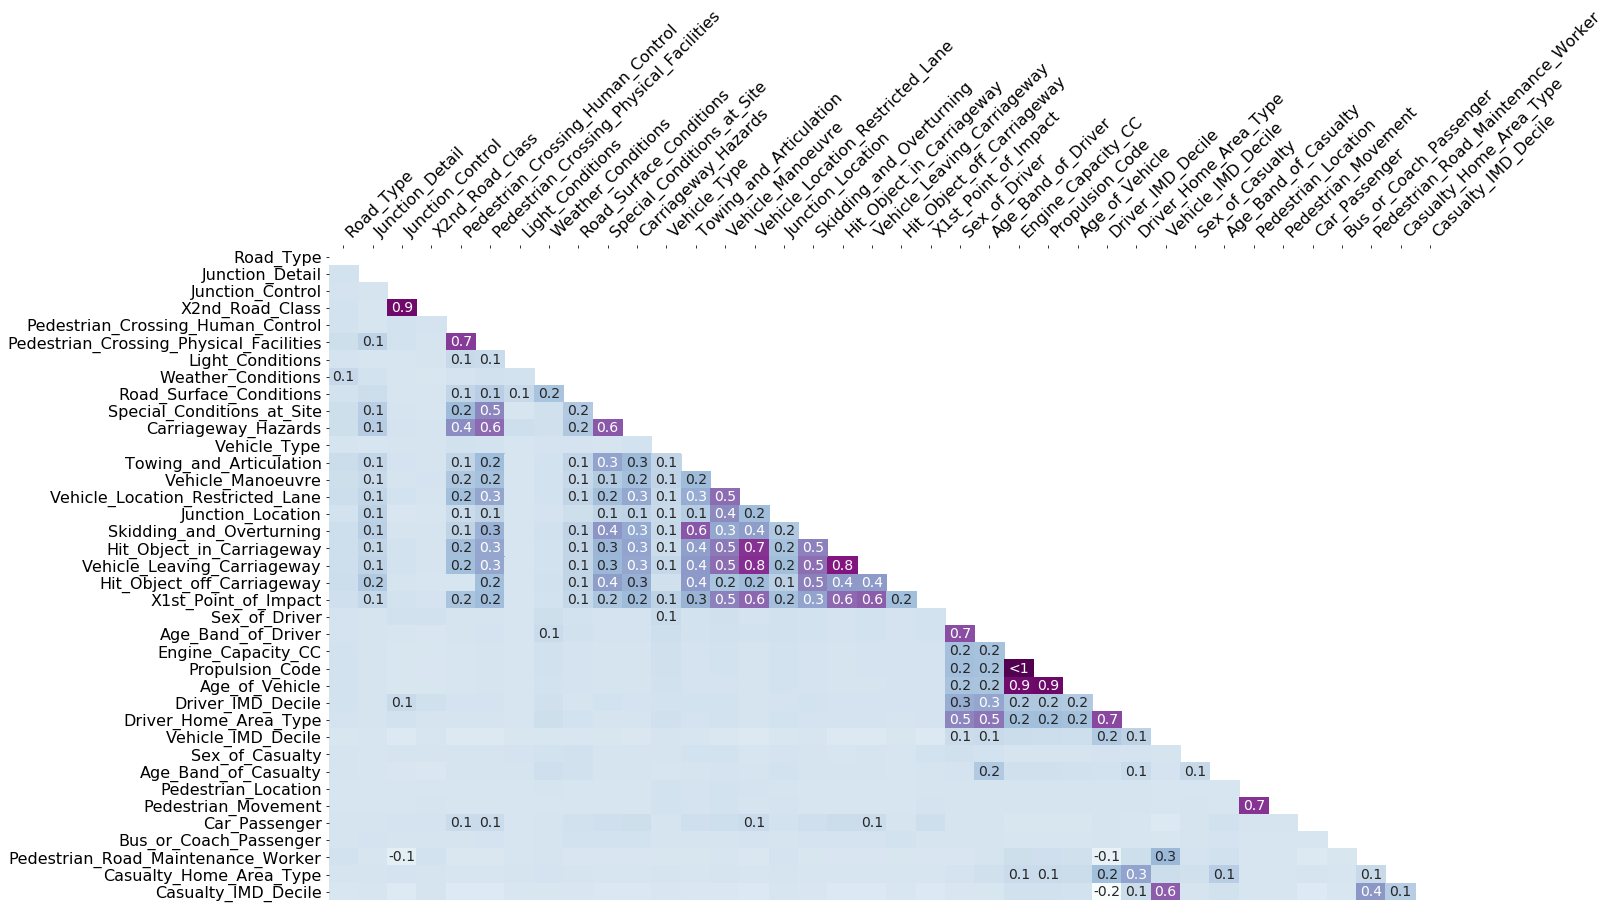

In [94]:
msno.heatmap(auto_drop(acc.merge(veh, on='Accident_Index', how='inner').merge(cas, on='Accident_Index', how='inner')), cmap='BuPu')

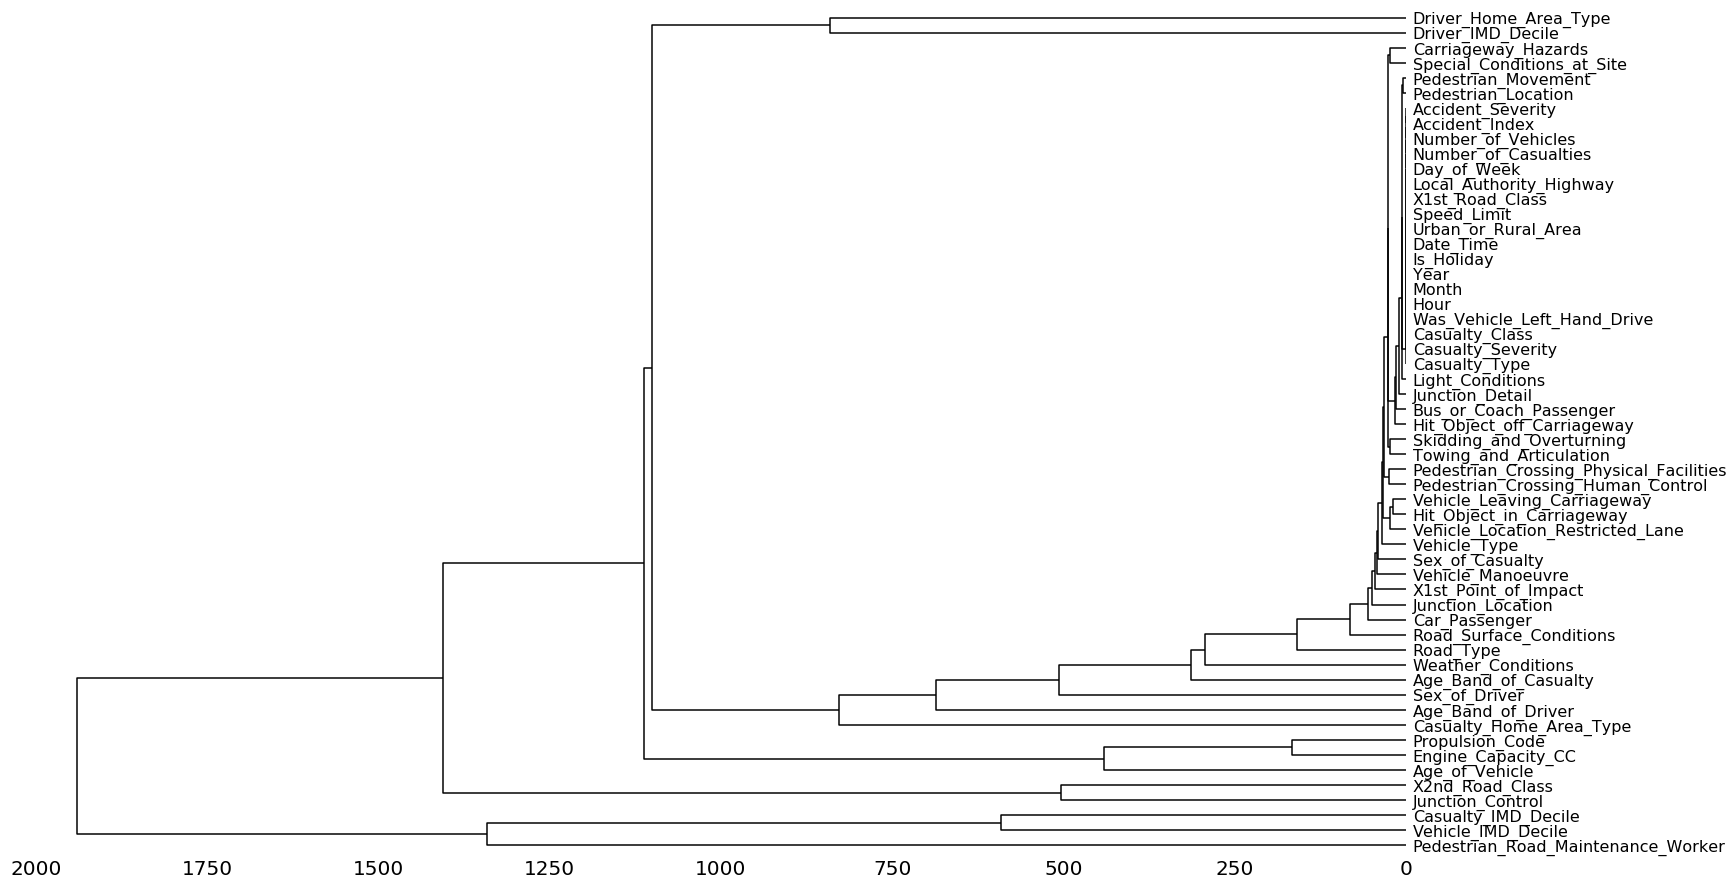

In [95]:
msno.dendrogram(auto_drop(acc.merge(veh, on = 'Accident_Index', how = 'inner').merge(cas, on='Accident_Index', how='inner')))

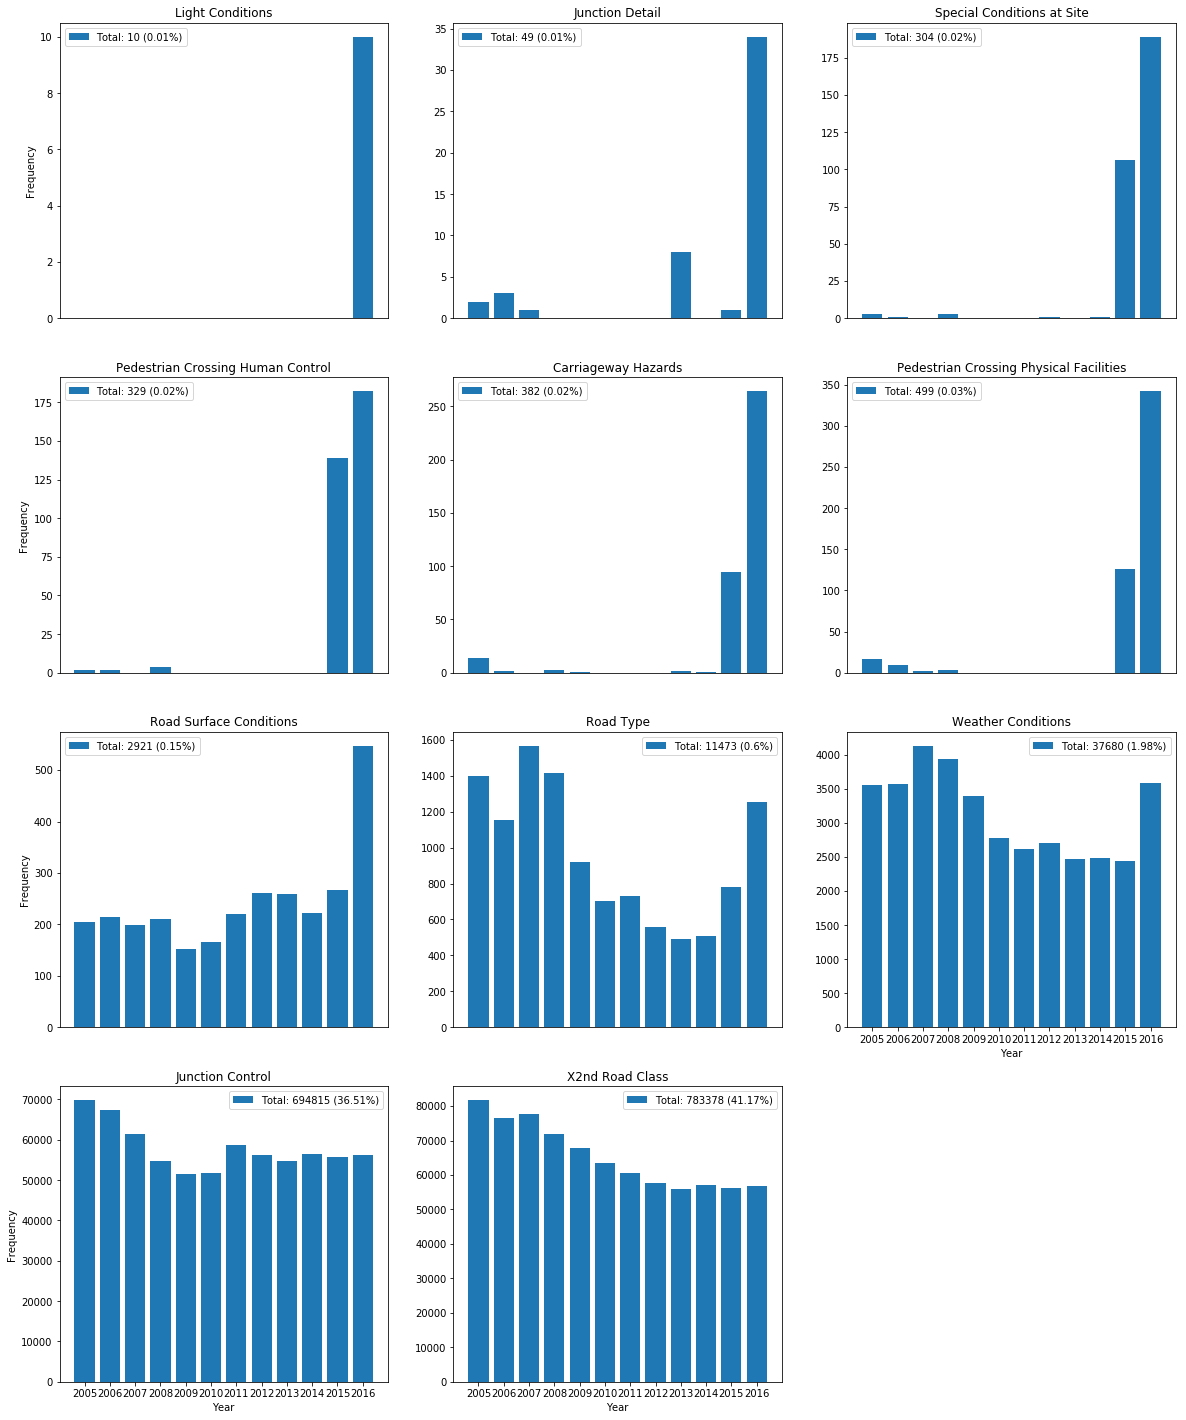

In [148]:
# How many are missing each year? Maybe survey is different by year
plot_yearly_missing_data_cols(data = auto_drop(acc), fig = plt.figure(figsize=[20,25]))
plt.show()

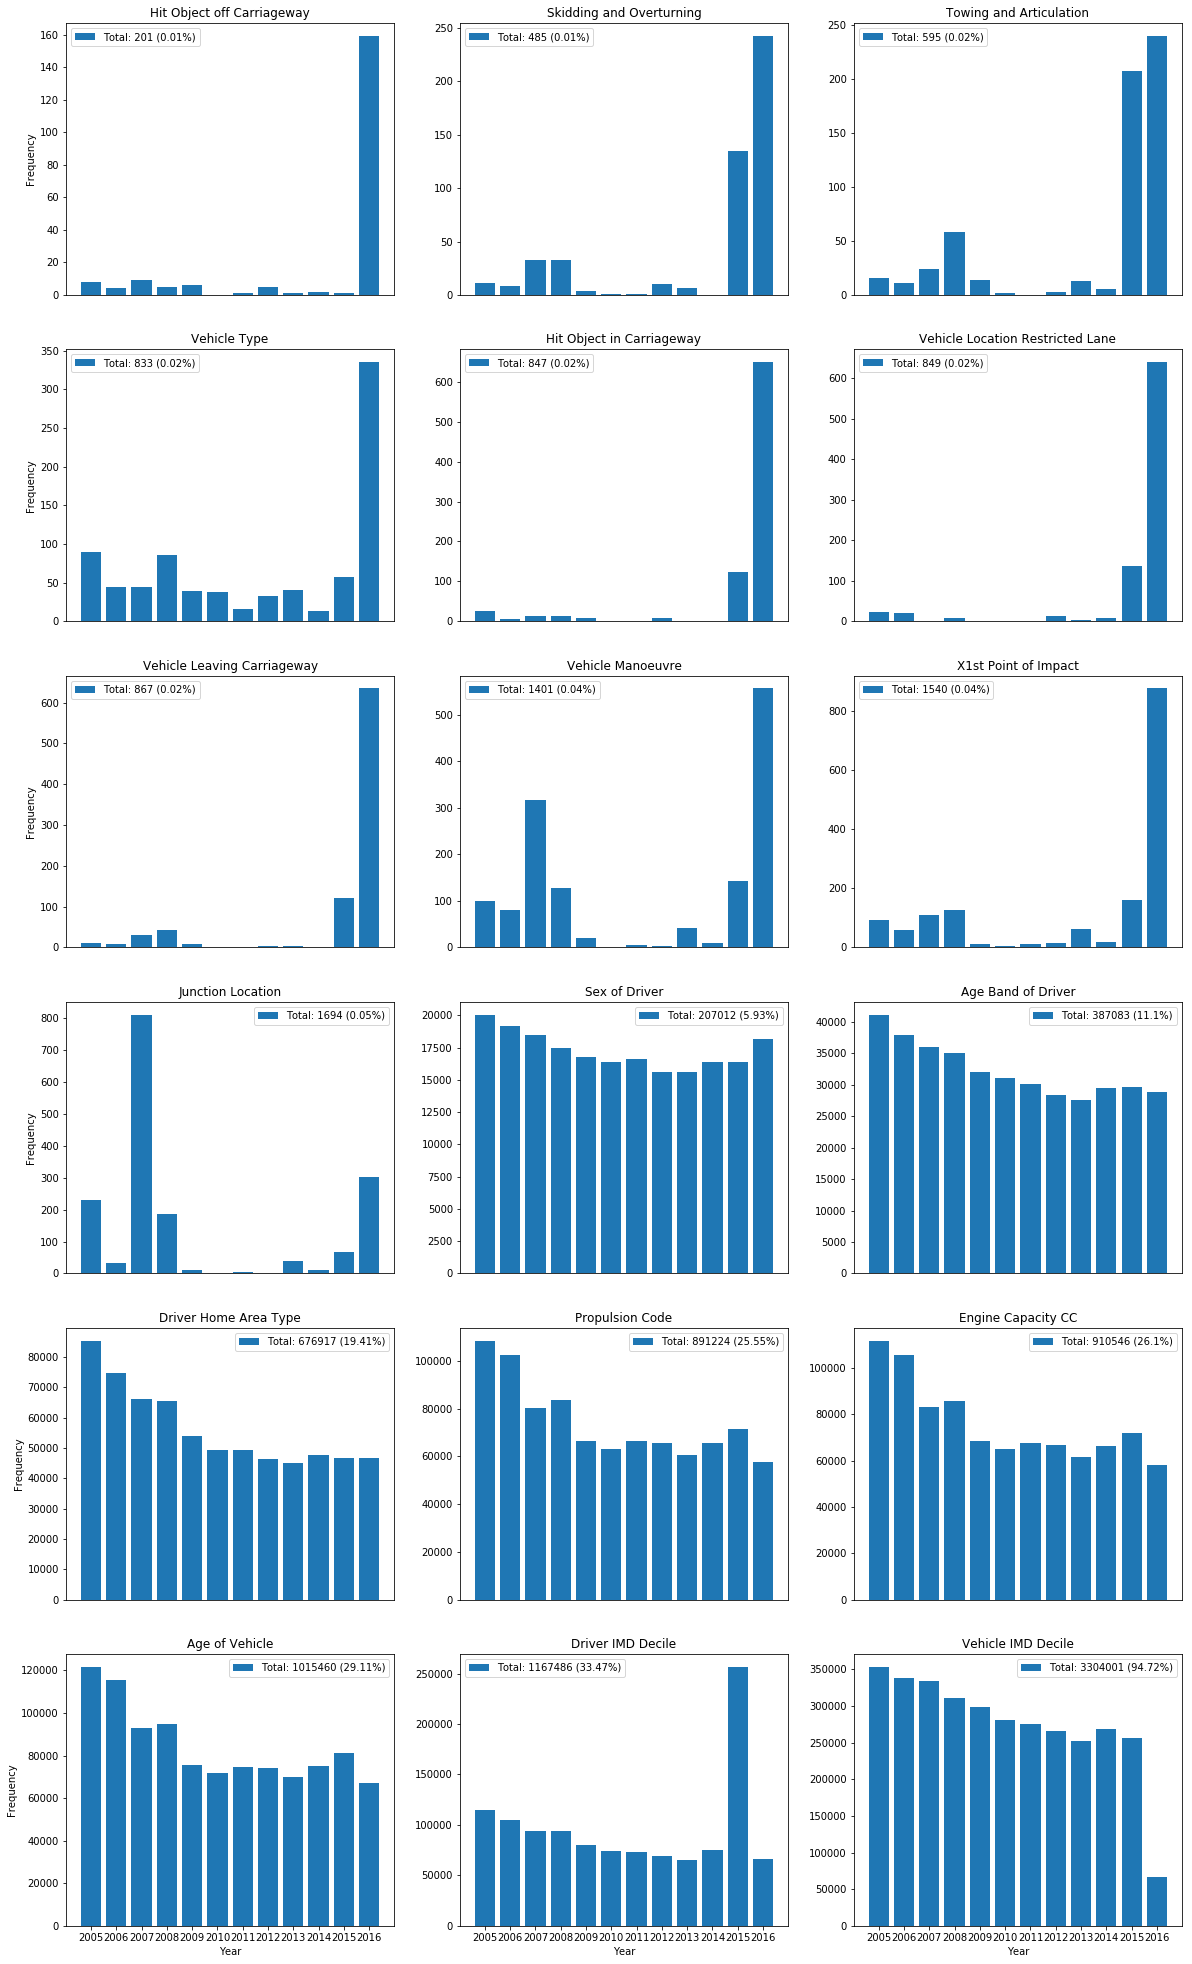

In [149]:
plot_yearly_missing_data_cols(data = auto_drop(veh.merge(acc.loc[:, ('Accident_Index', 'Year')], on = 'Accident_Index', how = 'inner')), 
                              fig = plt.figure(figsize=[20, 35]))
plt.show()

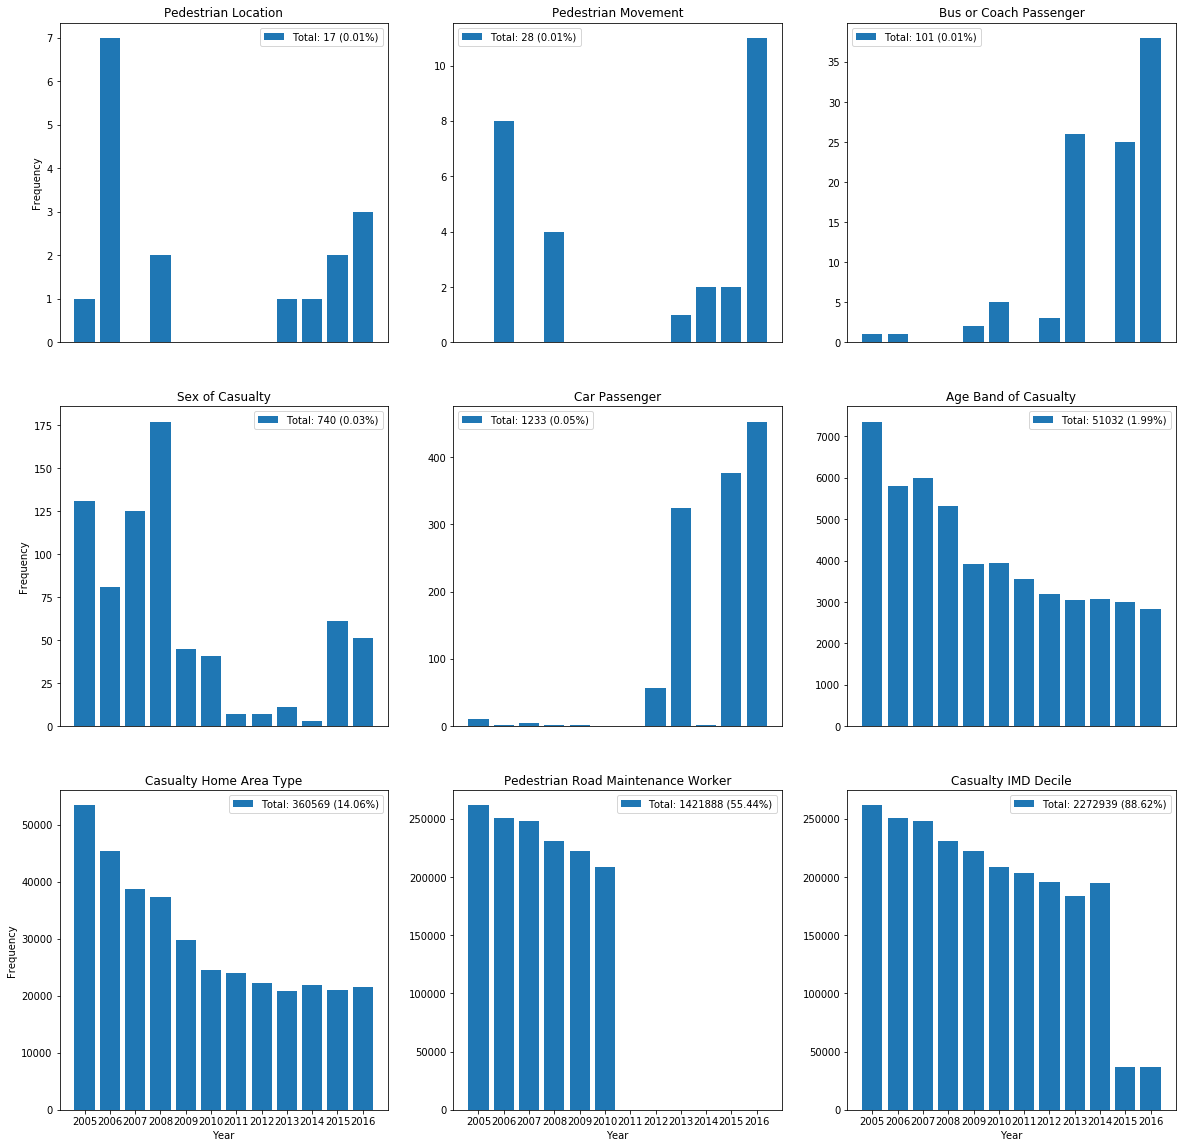

In [150]:
plot_yearly_missing_data_cols(data = auto_drop(cas.merge(acc.loc[:, ('Accident_Index', 'Year')], on = 'Accident_Index', how = 'inner')), 
                              fig = plt.figure(figsize=[20, 20]))
plt.show()

In [ ]:
###############END######################

# Analysis 2

In [ ]:
# import data
iacc = pd.read_csv(dirs["impute"] + "acc2005_2015-v2018.2.5.imp.csv").merge(acc[["Accident_Index", "Number_of_Casualties", "Local_Authority_Highway"]], how="left")
iveh = pd.read_csv(dirs["impute"] + "veh2005_2015-v2018.2.5.imp.csv")
icas = pd.read_csv(dirs["impute"] + "cas2005_2015-v2018.2.5.imp.csv")

## General

In [ ]:
iacc.columns

In [ ]:
# del icas, iveh, iacc, acc, cas, veh
##############END########################

## Feature Selection 2

## Modelling

In [130]:
# import model use data
tap = joblib.load("tap2005_2015-v2018.2.5.imp.model.pkl.z")
all_train_columns = np.invert(tap.columns.isin([
    'Accident_Index', 'Accident_Severity', 'Date_Time', 'Year'
]))
freq_columns = ['Number_of_Vehicles', 'Speed_Limit', 'Age_Band_of_Casualty', 'Number_of_Casualties']
cat_columns = tap.columns[all_train_columns].drop(freq_columns)
cas_columns = ['Casualty_Class', 'Pedestrian_Location', 'Pedestrian_Movement', 'Car_Passenger', 'Bus_or_Coach_Passenger', 'Casualty_Type', 'Sex_of_Casualty', 'Age_Band_of_Casualty', 'Number_of_Casualties']

In [151]:
sorted(tap["Age_Band_of_Casualty"].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

## Analysis

In [ ]:
baseline_ratio = np.divide(tap["Accident_Severity"].value_counts(), tap["Accident_Severity"].value_counts().sum())
every_year_num_of_acc = tap.groupby("Year").count()["Accident_Index"]
ratio_store = OrderedDict([
    (sev, []) for sev in sorted(pd.unique(tap["Accident_Severity"]))
])
for sev, _ in ratio_store.items():
    severity_count = tap[tap["Accident_Severity"] == sev].groupby("Year").count()["Accident_Index"]
    ratio_store[sev] = np.divide(severity_count, every_year_num_of_acc)

fig = plt.figure(figsize=[20,5])
ind = 131

for sev, ratio in ratio_store.items():
    ax = fig.add_subplot(ind)
    ax.bar(sorted(pd.unique(tap["Year"])), ratio)
    ax.axhline(baseline_ratio[sev], color="red")
    ax.set_title("Accident_Severity=" + accident_severity_mapping[sev])
    ax.set_xticks(sorted(pd.unique(tap["Year"])))
    ax.set_xlabel("Year")
    if ind == 131:
        ax.set_ylabel("Ratio to Total Accidents")
    ind += 1

In [ ]:
tap.columns[all_train_columns]